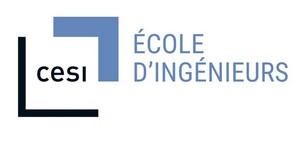

<h1 align='center'>Projet Leyenda - Livrable 2 - Traitement d'images</h1>
<h3 align='center'>Youssef AYARI, Matthieu DECLERCQ, Thomas PETAIN, Julien BARON, Jean-Baptiste CASTELLANI</h1>

## Sommaire

* [Introduction](#chapter1)
* [1. Contraintes](#chapiter2)
* [2. Configuration de l'environnement](#chapter3)
    * [2.1 Import des librairies Python](#section_3_1)
    * [2.2 Utilisation du GPU](#section_3_2)
* [3. Préparation du dataset](#chapter4)
    * [3.1 Création d'un jeu d'entraînement et de test](#section_3_1)
    * [3.2 Bruitage du jeu de données](#section_3_2)
    * [3.3 Augmentation des performances du dataset](#section_3_3)

## Introduction <a class="anchor" id="chapter1"></a>

<div style="text-align: justify">Dans le cadre de ce projet, l'entreprise TouNum, spécialisée dans la numérisation de documents, souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possède une grande quantité de données à numériser au format papier. Dans le but de rester compétitif dans ce secteur d’activité, l’entreprise décide d’innover et de proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science du CESI ont été contactés.
<p><br>
    
<div style="text-align: justify">Dans la partie précedente nous avons classifié les photos et les autres images par le biais d'un CNN. Dans ce notebook nous abroderons le débruitage des photos afin de faciliter leur traitement par les algorithmes de machine Learning</div>

## 1. Contraintes <a class="anchor" id="chapter2"></a>

<div style="text-align: justify">Dans le but d'opérer une opération de débruitage nous devons réfléchir à une méthode qui nous permettra de réduire la dimension de notre image. En effet, lorsque nous traitons des images nous avons beaucoup de caractéristiques en entrée. Prenons une image 28 x 28 pixel, dans ce cas nous aurons 784 inputs dans notre réseau de neurones. Avec autant de dimension ce qui rend le traitement et l'analyse compliqué.</div><br>

<div style="text-align: justify">Nous connaissons des méthodes permettant de réduire les dimensions de notre image. Nous pouvons citer dans un premier temps l'ACP ( Analyse en Composantes Principale). Néanmoins cette solution ne nous satisfait pas car les relations entre les caractéristiques et les points de données dans un espace à haute dimension présentent une relation non linéaire.</div><br>

<div style="text-align: justify">Dans ce cas de figure nous pouvons alors nous tourner vers le TSNE. Néanmoins, cet algorithme bien que très efficace ne convainc pas du fait qu'il reste très gourmand en ressources. Par conséquent nous nous devons trouver un algorithme qui nous permet de garder une approche non linéaire tout en conservant des performances acceptables.</div><br>


## 2. Configuration de l'environnement <a class="anchor" id="chapter3"></a>

Tout comme dans le premier livrable nous nous devons de préparer notre environnement de travail pour mener à bien notre projet. Par conséquent nous reviendrons sur les mêmes points qui ont été aborder précédemment qui sont : l'import des librairies Python et l'utilisattion du GPU. 

### 2.1 Import des librairies Python <a class="anchor" id="section_3_1"></a>

Dans le cadre de ce premier livrable, nous avons décidé d’importer plusieurs librairies Python que nous allons présenter :
<ul>
    <li style="text-align: justify"><strong>TensorFlow</strong> : est un outil open source d'apprentissage automatique développé par Google. Il est l'un des outils les plus utilisés en IA dans le domaine de l'apprentissage machine. Celui-ci contient de nombreuses implémentations de blocs nécessaire à la construction de réseaux de neurones couramment utilisés tels que des couches, des fonctions d'activation, des optimiseurs et une multitude d'outils pour faciliter le travail avec des images ou des textes afin de simplifier le codage nécessaire à l'écriture de code de réseau de neurones profond. <strong>Keras</strong> est l’API haut niveau s’exécutant sur la plateforme d’apprentissage automatique Tensorflow. Elle permet de faciliter la création et l’entraînement des modèles de deep learning.</li><br>
</ul>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import numpy as np

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from random import randrange
from tensorflow.keras.preprocessing import image
# from skimage.util import random_noise
# from PIL import Image
# from tensorflow.keras.preprocessing import image

### 2.2 Utilisation du GPU <a class="anchor" id="section_2_1"></a>

<div style="text-align: justify">Dans l'optique d’avoir de meilleures performances tout au long de ce projet notamment durant l’entraînement du modèle, nous avons décidé de faire passer le traitement des données par le GPU. Pour ce faire, la ligne ci-dessous nous indique si le système détecte un GPU qui peut être utilisé. (Seules les cartes Nvdia avec Cuda installé sont reconnues par Tensorflow).<div>

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 3. Préparation du dataset <a class="anchor" id="chapter4"></a>

<div style="text-align: justify"> Nous avons vu comment dans le premier livrable comment préparer notre jeux de données pour les algorithme de deep learning. Néanmoins, nous devrons rajouter intentionellement du bruit sur nos images dans le but de pouvoir entrainer nos modèles dans les meilleures conditons.</div>

In [3]:
data_dir = "D:\exia\A5 2021-2022\Option_DataScience\Data"

image_h = 416
image_w = 416
batch_s = 32

### 3.1 Création des jeux d'entrainement et de test <a class="anchor" id="section_4_1"></a>

<div style="text-align: justify">Pour préparer le jeu de données, nous le séparons en deux sous-ensembles homogènes afin d'éviter la sous-représentation de classe. Le premier sous-ensemble dit d'entraînement permettra au modèle d'ajuster ses poids et par conséquent améliorer sa classification. Le second nous permet d'évaluer la classification du modèle. C'est sur ce jeu de données qu'on se base pour le calcul de la précision du modèle.<div>   

In [4]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode="rgb"
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode="rgb"
)

Found 13747 files belonging to 1 classes.
Using 10998 files for training.
Found 13747 files belonging to 1 classes.
Using 2749 files for validation.


### 3.2 Bruitage du jeu de données <a class="anchor" id="section_4_2"></a>

<div style="text-align: justify">Notre dataset ne contenant pas d'image bruitée, nous devons par conséquent ajouter un bruit gaussien aléatoire sur chaque image. Pour ce faire nous générons aléatoirement un entier que nous multiplions par un facteur et additionnons à notre image.</div>

In [5]:
def preprocess(data):
    data = np.array(data, dtype=np.float32)
    data = data.astype('float32') / 255.0
    data = np.reshape(data, (len(data), image_h, image_w, 3))
    return data

def noise_it(data, noise_factor = 0.2):
    data_noisy = data + noise_factor * tf.random.normal(shape = data.shape)
    return np.clip(data_noisy, 0., 1.)
    

def split_dataset(data):
    for photo_batch, label_batch in data:
        photo = photo_batch
        break
    return photo

x_train = split_dataset(train_set)
x_test = split_dataset(test_set)

# x_train = np.concatenate([x for x, y in train_set], axis = 0)
# x_test = np.concatenate([x for x, y in test_set], axis = 0)

x_train = preprocess(x_train)
x_test = preprocess(x_test)

x_train_noisy = noise_it(x_train)
x_test_noisy = noise_it(x_test)

Nous pouvons voir ci-dessous que les images issus de notre dataset on bien été bruité.

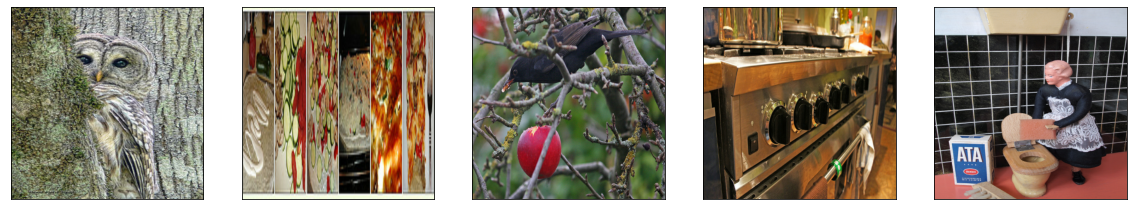

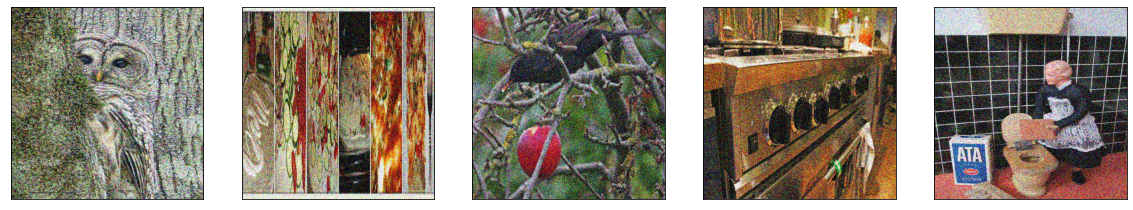

In [6]:
def display_image(X, n):
    plt.figure(figsize=(20, 20))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(x_train,5)
display_image(x_train_noisy, 5)

### 3.3 Augmentation des performances du dataset <a class="anchor" id="section_4_3"></a>

Afin d'améliorer les performances du dataset nous pouvons mettre en place différentes méthodes :
- `Dataset.cache()`: <div style="text-align: justify">Cette fonction nous permettra de garder les données dans la mémoire cache. En effet, notre modèle doit repasser plusieurs fois sur les données d'entraînement à chaque epoch. De cette façon, le rechargement des données est grandement réduit entre chaque epoch.</div><br>
- `Dataset.prefetch()`: <div style="text-align: justify">Nous permet de paralléliser le traitement des batchs par le modèle. Pour ce faire, lors de l'entraînement/évaluation du batch en cours nous commençons le prétraitement du batch suivant.</div>   

In [7]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# x_train_noisy = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# x_test_noisy = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## 4 Création du modèle <a class="anchor" id="chapiter4"></a>

In [8]:
nb_epochs = 100
latent_space_dim = 15

In [9]:
inputs = Input(shape=(image_w, image_w, 3))

x = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, x)
autoencoder.compile(optimizer="adadelta", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 416, 416, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 416, 416, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 208, 208, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 208, 208, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 104, 104, 8)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 104, 104, 8)       584   

In [10]:
history = autoencoder.fit(
    x=x_train_noisy,
    y=x_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.6927 - val_loss: 0.6934
Epoch 2/100
1/1 [==============================] - 0s 438ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 3/100
1/1 [==============================] - 0s 443ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 4/100
1/1 [==============================] - 0s 441ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 5/100
1/1 [==============================] - 0s 436ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 6/100
1/1 [==============================] - 0s 428ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 7/100
1/1 [==============================] - 0s 420ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 8/100
1/1 [==============================] - 0s 434ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 9/100
1/1 [==============================] - 0s 456ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 10/100
1/1 [==============================] - 0s 437ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 11/100

1/1 [==============================] - 0s 454ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 84/100
1/1 [==============================] - 0s 419ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 85/100
1/1 [==============================] - 0s 426ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 86/100
1/1 [==============================] - 0s 427ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 87/100
1/1 [==============================] - 0s 449ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 88/100
1/1 [==============================] - 0s 433ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 89/100
1/1 [==============================] - 0s 448ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 90/100
1/1 [==============================] - 0s 414ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 91/100
1/1 [==============================] - 0s 425ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 92/100
1/1 [==============================] - 0s 436ms/step - loss: 0.6927 - val_loss: 0.6934
Epoch 93/100


In [11]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_h, image_h, 3)))
# model.add(MaxPooling2D((2, 2), padding='same'))
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2), padding='same'))
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
 

# model.add(MaxPooling2D((2, 2), padding='same'))
     
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(28, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

In [12]:
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [13]:
# model.fit(x_train_noisy, x_train, epochs=10, batch_size=8, shuffle=True, verbose = 1)

In [14]:
# input_img = Input(shape=(image_w, image_h, 3))
# conv1_1 = Conv2D(32, (3,3), activation="relu", padding="same")(input_img)
# pool1_1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
# conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1_1)
# pool1_2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
# conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1_2)
# pool1_3 = MaxPooling2D((2, 2), padding='same')(conv1_3)

# conv2_1 = Conv2D(8, (3,3), activation="relu", padding="same")(pool1_3)
# pool2_1 = UpSampling2D()(conv2_1)
# conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2_1)
# pool2_2 = UpSampling2D()(conv2_2)
# conv2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2_2)
# pool2_3 = UpSampling2D()(conv2_3)
# conv2_3 = Conv2D(3, (3, 3), activation='relu', padding='same')(pool2_3)

In [15]:
# autoencoder = Model(input_img, conv2_3)
# autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(), #"Adadelta" ne marche pas,
#                     loss="binary_crossentropy") 
# autoencoder.summary()

In [16]:
# ## Train the model
# history = autoencoder.fit(x_train_noisy, x_train,
#                 epochs=nb_epochs,
#                 batch_size= batch_size,
#                 shuffle= False,
#                 validation_data=(x_test_noisy, x_test)
#                 )

In [17]:
# # Visualisation des pertes d'apprentissage (Train) et de validation (Test)
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()

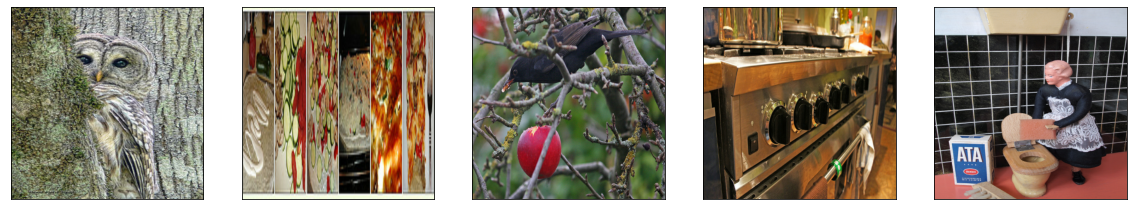

In [18]:
display_image(x_train,5)

In [19]:
# encoder_inputs = Input(shape = (image_h, image_w, 3))

# conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_inputs)
# pool1 = MaxPooling2D(padding='same')(conv1_1)
# conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
# pool2 = MaxPooling2D(padding='same')(conv1_2)
# conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
# h = MaxPooling2D(padding='same')(conv1_3)

# conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
# up1 = UpSampling2D()(conv2_1)
# conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
# up2 = UpSampling2D()(conv2_2)
# conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
# up3 = UpSampling2D()(conv2_3)
# decoder_outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

In [20]:
# inputs    = keras.Input(shape=(image_h, image_h, 3))
# x         = Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
# x         = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x         = Flatten()(x)
# x         = Dense(16, activation="relu")(x)
# z         = Dense(latent_space_dim)(x)

# encoder = keras.Model(inputs, z, name="encoder")

In [21]:
# inputs  = keras.Input(shape=(latent_space_dim,))
# x       = Dense(7 * 7 * 64, activation="relu")(inputs)
# x       = Reshape((7, 7, 64))(x)
# x       = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x       = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# outputs = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

# decoder = keras.Model(inputs, outputs, name="decoder")

In [22]:
# inputs    = keras.Input(shape=(image_h, image_h, 3))

# latents   = encoder(inputs)
# outputs   = decoder(latents)

# ae = keras.Model(inputs,outputs, name="ae")

# ae.compile(optimizer=keras.optimizers.Adadelta(), loss='binary_crossentropy')

In [23]:
# history = ae.fit(x_train_noisy, x_train,
#                  batch_size      = batch_s,
#                  epochs          = nb_epochs,
#                  validation_data = (x_test_noisy, x_test) )

In [24]:
#autoencoder.compile(optimizer='adadelta', loss='mse')

In [25]:
# history = autoencoder.fit(x_train_noisy, x_train,
#                 epochs=nb_epochs,
#                 batch_size= batch_s,
#                 shuffle= True,
#                 validation_data=(x_test_noisy, x_test)
                         #)

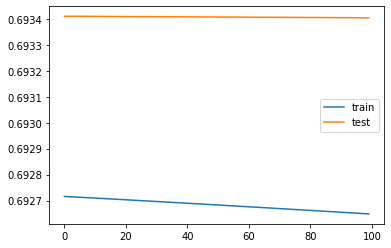

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [27]:
def get_image_test():
    path_test_photo = "D:\exia\A5 2021-2022\Option_DataScience\Dataset"
    test_image = [os.path.join(path_test_photo, x) for x in os.listdir(path_test_photo)][randrange(150)]
    return test_image

def do_test(photo_test, model):
    img = image.load_img(photo_test)
    img = preprocess(img)
    img_noise = noise_it(img)
    img_denoise_encoder = ae.predict(img_noise)
    print(img_denoise_encoder)
    display_image(img, 1)
    display_image(img_noise, 1)
    display_image(img_denoise_encoder, 1)
# test_image = get_image_test()
# do_test(test_image, history)

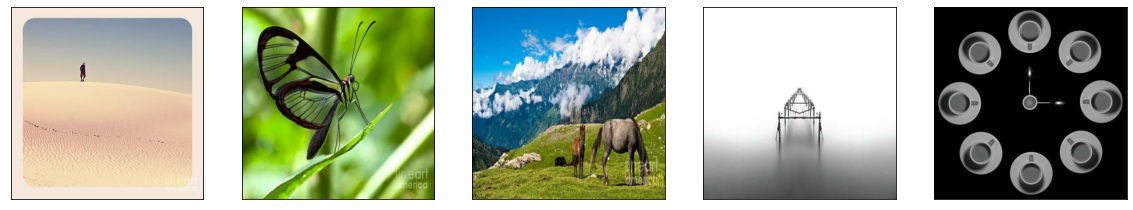

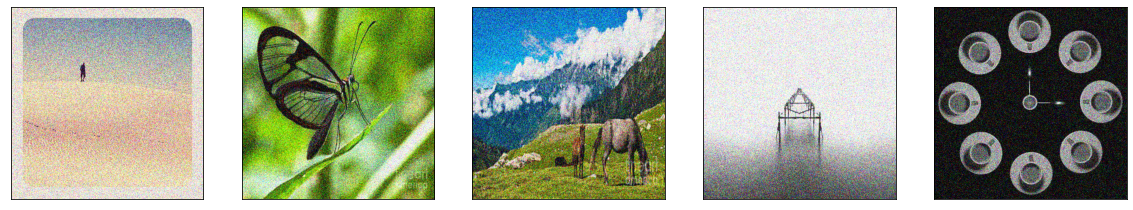

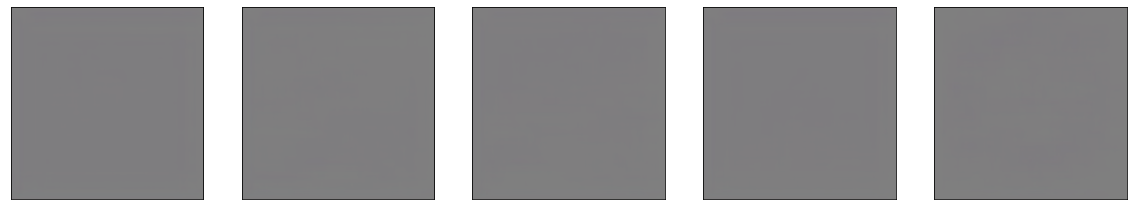

In [28]:
predictions = autoencoder.predict(x_test_noisy)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

In [29]:
# input_img = Input(shape = (image_h, image_h,3))
# x = Conv2D(16, (3,3), activation = "relu", padding="same")(input_img)
# x = MaxPooling2D(pool_size=(2,2), padding="same")(x)
# x = Conv2D(32, (3,3), activation = "relu", padding="same")(x)
# encoded = MaxPooling2D()(x)
# x = Conv2D(32, (3,3), activation = "relu", padding="same")(encoded)
# x = UpSampling2D((2))(x)
# x = Conv2D(32, (3,3), activation = "relu", padding="same")(x)
# x = UpSampling2D()(x)
# decoded = Conv2D(3, (3, 3), activation= "sigmoid", padding="same")(x)

In [30]:
# inputs    = tf.keras.Input(shape=(28, 28, 3))

# latents   = encoder(inputs)
# outputs   = decoder(latents)

# ae = tf.keras.Model(inputs,outputs, name="ae")

# ae.compile(optimizer = tf.keras.optimizers.Adadelta(), loss = 'mse')
# ae.summary()

In [31]:
# autoencoder = tf.keras.Model(input_img, decoded)
# autoencoder.compile(optimizer="adadelta",
#                     loss= "binary_crossentropy")
# autoencoder.summary()

In [32]:
# history = ae.fit(x_train_noisy, x_train,
#                 epochs=nb_epochs,
#                 batch_size= batch_size,
#                 shuffle= False,
#                 validation_data=(x_test_noisy, x_test)
#                          )


In [33]:
# def create_dir():
#     bruit_dir = "D:\exia\A5 2021-2022\Option_DataScience\Bruit"
#     if not os.path.exists(bruit_dir):
#         print('test')
#         os.mkdir(bruit_dir)
#         dir_create = map(lambda x : os.path.join(bruit_dir,x), ['Bruit', 'Clean'])
#         [os.mkdir(x) for x in dir_create]
#     return list(map(lambda x: bruit_dir + '\\'+ x ,os.listdir(bruit_dir)))

# def noise_it(list_dir, path_dataset):
#     all_files = [os.path.join(path_dataset, x) for x in os.listdir(path_dataset)]
#     for index, photo in enumerate(all_files):
#         img = image.load_img(photo, target_size=(28, 28))
#         array_img = image.img_to_array(img)
# #         array_img = random_noise(array_img, mode='gaussian', mean=0, var=0.3)
# #         array_img = random_noise(array_img, mode='s&p',      amount=0.2, salt_vs_pepper=0.5)
# #         array_img = random_noise(array_img, mode='poisson') 
# #         array_img = random_noise(array_img, mode='speckle',  mean=0, var=0.1)
# #         array_img = Image.fromarray(array_img.astype('uint8'), 'RGB')
#         img.save(str(list_dir[1]) + "\\"+ photo.split('\\')[-1])
#         array_img.save(str(list_dir[0]) + "\\noisy_"+ photo.split('\\')[-1])
# list_dir = create_dir()
# noise_it(list_dir, r"D:\exia\A5 2021-2022\Option_DataScience\Datasets\Photo")